# Blackbox Optimization with Linear and Logarithmic models

In [1]:
## Libraries
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# https://docs.scipy.org/doc/scipy/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs
import scipy.optimize as optimize

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [2]:
# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_models import *

2023-08-29 11:45:08.437076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


# Step 1: Synthetic data

## Why synthetic data?
Synthetic data is information that's artificially manufactured rather than generated by real-world events. It's created algorithmically and is used as a stand-in for test data sets of production or operational data, to validate mathematical models and to train machine learning (ML) models.

## Create synthetic data

In [3]:
# time discretization
Nt, T = 100, 10                             # Number of time steps, final time
ts = np.linspace(0, T, Nt)                  # timespan

N = 5                                       # numbers of vehicles
X0 = sorted(np.random.uniform(size=N)*100)  # initial condition
v0, L = 2, 3                                # control param
flag = "Lin"
args=(N, v0, L, flag)

In [4]:
## Solve the ode with "odeint"
X = odeint(TD_LWR_model, X0, ts, args=(N, v0, L, flag), tfirst = True).T # take the transpose to get N trajs!

In [5]:
# Take samples from the simulation
M = 10           # Number of samples
Mt = int(Nt/M)   # timestamp to take equispaced samples

idx = list(range(0,Nt,Mt+1))    # indexes to extract
tshat, Xhat = ts[idx], [traj[idx] for traj in X]

In [6]:
idx

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [7]:
tshat

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [8]:
Xhat

[array([70.4794068 , 72.04183749, 73.51571522, 74.89773078, 76.19097913,
        77.40519382, 78.55542638, 79.65947412, 80.73502872, 81.79754854]),
 array([81.26857912, 81.52440447, 81.90964175, 82.4249305 , 83.05939906,
        83.79802539, 84.62636311, 85.53196563, 86.50449993, 87.53547027]),
 array([84.55290225, 85.02789047, 85.67421157, 86.47774315, 87.40778846,
        88.43898962, 89.55237421, 90.73381278, 91.97261162, 93.26051211]),
 array([ 88.22676816,  89.03499683,  90.14225405,  91.41374039,
         92.79303489,  94.25011524,  95.76674638,  97.33086994,
         98.93401841, 100.56997671]),
 array([ 92.23454877,  94.45677099,  96.67899322,  98.90121544,
        101.12343766, 103.34565988, 105.56788211, 107.79010433,
        110.01232655, 112.23454877])]

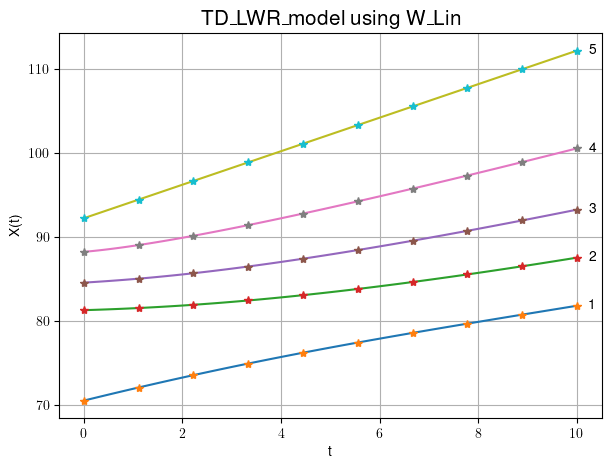

In [9]:
# fig 
width, height = 7, 5
# palette = 'darkblue'
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    # X.T (transposed) is the list of trajectories of the vehicles
    ax.plot(ts, X[veh])
    ax.plot(tshat, Xhat[veh], '*')

# Annotate the name of each variable at the last value
scale = 1.025
last_val = X[:,-1].tolist()
coords = zip([T*scale]*N,last_val) # last value where I want to annotate the corresponding label
labels = list(range(1,N+1,1))

for coord,lab in zip(coords,labels):
    ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                xytext=coord,                # The position (x, y) to place the text at.
#                 textcoords='offset points',
                text=lab,
                verticalalignment='center')

    
ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(f"TD_LWR_model using W_{flag}", fontsize=15)
plt.grid()
plt.show()

# Step 2: Optimization with blackbox approach

In [10]:
#A = np.array([np.random.sample(N)*20 for i in range(0,Mt)])

In [11]:
# definition with freezed parameteres X0, N, ts and flag.
def f(v0,L):
    return odeint(TD_LWR_model, X0, ts, args=(N, v0, L, flag), tfirst = True).T

In [12]:
def loss_fun(params):
    "Loss function"
    
    v0, L = params # whereas X0, N, ts and flag are fixed
    X = f(v0,L)
        
    # extracting the same index as the sampled one
    Xupd = [traj[idx] for traj in X]
            
    mse = mean_squared_error(Xhat, Xupd)
    return mse

In [13]:
# using the parameters used in the creation of synthetic data the loss must be 0!
loss_fun([v0,L])

0.0

In [14]:
v0, L

(2, 3)

In [15]:
initial_guess = [3,9]

# first attempt: without using Jac
result = optimize.minimize(loss_fun, initial_guess, method="CG")
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1187916582449D+01   r2 =  0.9677760250523D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1187916582449D+01   r2 =  0.9677760250523D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1187916582449D+01   r2 =  0.9677760250523D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1187916582454D+01   r2 =  0.9920504195288D-16
 lsoda--  warning..internal t (=r1) 

/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [16]:
fitted_params.tolist()

[1.9999994693915002, 2.9999988667708757]